# ML Assignment. Linear Models.

#### Atuhor: Josep Carreras
#### Date: 01/07/2019

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split #Split arrays or matrices into random train and test subsets
from sklearn.metrics import mean_squared_error
import itertools

### Just for plotting nice colors on terminal

In [38]:
class bcolors:
    HEADER = '\033[95m'; OKBLUE = '\033[94m'; OKGREEN = '\033[92m'; WARNING = '\033[93m'
    FAIL = '\033[91m'; ENDC = '\033[0m'; BOLD = '\033[1m'; UNDERLINE = '\033[4m'

### This is just to see wider columns on Pandas

In [39]:
pd.set_option("display.max_columns",300)

### Import the dataset

In [40]:

carseats = pd.read_csv('carseats.csv')
carseats = carseats.drop(columns='Unnamed: 0')

### Function that calculates all possible combinations of N columns (2^N-1)

In [41]:
def get_column_combinations(df, predict_on='Sales'):
     df.drop(predict_on, axis=1, inplace=True)
     col = list(range(len(df.columns)))
     col_list = []
     col_num_list = []
     for L in range(1, len(col)+1):
          for subset in itertools.combinations(df.keys(), L):
               col_list.append(subset)
               #print(subset)
          for subset in itertools.combinations(col, L):
               col_num_list.append(subset)
               #print(subset)
     return col_list, col_num_list

### Encode categorical data, accepted encodings: ordinal, binary, hot-one

In [42]:
def encode_categorical(df, ordinal_list=[], order=[], binary_list = []):
     # check this out: https://www.kaggle.com/getting-started/27270
     #order is a list of the same length of ordinal_list, that specifies the order of the labels in ascending order
     #oder is always a list of lists!
     columns_to_encode = list(df.select_dtypes(include=['category', 'object']))
     i = 0
     for col in columns_to_encode:
          if col in ordinal_list:
               # since it is categorical but ordinal we want to preserve the order:
               df[col + '_ordinal_encoded'] = df[col].map({order[i][j]: j for j in range(len(order[i]))})
          else:
               elements = list(set(df[col]))
               if col in binary_list: #binary variable
                    df[col + '_binary_encoded'] = df[col].map({elements[0]: 1, elements[1]: 0})
               else: # categorical non-binary and non-ordinal --> one hot encoding
                    df = pd.concat([df, pd.get_dummies(df[col], prefix=col+'_is')], axis=1)
          df.drop(col, axis=1, inplace=True)
     return df

### Standarizes a dataset (X-mean(X))/std(X)

In [43]:
def standarize_dataset(df):
     scaler = StandardScaler()
     df = scaler.fit_transform(df)
     return df, scaler

### Print best result found so far in the main loop

In [44]:
def print_info(i, ncol, e, col, score, intercept, coeffs):
    print(bcolors.WARNING + bcolors.UNDERLINE + f'Iteration {i}:' + bcolors.ENDC)
    print(
        bcolors.OKGREEN + f'\tTotal Columns (numerical + categorical): ' + bcolors.ENDC + bcolors.FAIL + f'Columns = {ncol}' + bcolors.ENDC)
    print(
        bcolors.OKGREEN + f'\tTotal Columns number of tests: ' + bcolors.ENDC + bcolors.FAIL + f'# of tests: = {2**ncol-1}' + bcolors.ENDC)
    print(
        bcolors.OKGREEN + f'\tFOUND LOWEST ERROR SO FAR: ' + bcolors.ENDC + bcolors.FAIL + f'RMSE = {e:.4}' + bcolors.ENDC)
    print(bcolors.OKGREEN + f'\tTHE BEST PREDICTORS ARE: ' + bcolors.ENDC + bcolors.FAIL + f'{list(col)}.' + bcolors.ENDC)
    print(bcolors.OKGREEN + f'\tScore: ' + bcolors.ENDC + bcolors.FAIL + f'{score:.5}.' + bcolors.ENDC)
    print(bcolors.OKGREEN + f'\tIntercept: ' + bcolors.ENDC + bcolors.FAIL + f'{intercept:.5}.' + bcolors.ENDC)
    print(bcolors.OKGREEN + f'\tCoefficients: ' + bcolors.ENDC + bcolors.FAIL + f'{coeffs}.' + bcolors.ENDC)

### Plot Error between Test scaled Sales and Predicted scaled Sales

In [45]:
def plot_predicted(y_test, y_predicted, error=[], labels=['','']):
    plt.clf()
    plt.plot(range(len(y_test)), y_test, 'kx-', label=labels[0], lw=2)
    plt.plot(range(len(y_test)), y_predicted, 'rx-', label=labels[1], lw=2)
    plt.legend()
    plt.ylabel('RMSE')
    plt.xlabel('Sample number')
    if error:
        plt.title(f'Error between Test scaled Sales and Predicted scaled Sales (RMSE={error:.3})')
    else:
        plt.title('Error between Test scaled Sales and Predicted scaled Sales')
    x = range(len(y_test))
    y1 = y_test
    y2 = y_predicted
    plt.plot(sharex=True)
    ax = plt.gca()
    ax.plot(x, y1, x, y2, color='black')
    ax.fill_between(x, y1, y2, where=y2 >= y1, facecolor='green', interpolate=True)
    ax.fill_between(x, y1, y2, where=y2 <= y1, facecolor='red', interpolate=True)
    plt.show()

## Main function

### Encode Categorical Variables

In [46]:
    #Todo OPTION 1: CATEGORICAL = 1 Ordinal + 2 binary
    carseats_encoded = encode_categorical(
        carseats.copy(), ordinal_list=['ShelveLoc'], order=[['Bad', 'Medium', 'Good']], binary_list=['Urban', 'US'])
    #Todo OPTION 2: CATEGORICAL = 1 Ordinal + 2 One-hot
    #carseats_encoded = encode_categorical(
    #    carseats.copy(), ordinal_list=['ShelveLoc'], order=[['Bad', 'Medium', 'Good']])
    #Todo OPTION 3: CATEGORICAL = All One-hot enconding

### Apply StandardScaler to the dataset

In [47]:
    carseats_scaled, scaler = standarize_dataset(carseats_encoded.copy())
    carseats_scaled = pd.DataFrame(carseats_scaled, columns=carseats_encoded.columns)

### Remove standard scaling if needed

In [48]:
# carseats_scaled = carseats_encoded

### Generate all possible combinations of N columns ($2^{N-1}$ possibilities)

In [49]:
    column_name_combinations, column_index_combinations = \
        get_column_combinations(carseats_scaled.copy(), predict_on='Sales')

('CompPrice',)
('Income',)
('Advertising',)
('Population',)
('Price',)
('Age',)
('Education',)
('ShelveLoc_ordinal_encoded',)
('Urban_binary_encoded',)
('US_binary_encoded',)
(0,)
(1,)
(2,)
(3,)
(4,)
(5,)
(6,)
(7,)
(8,)
(9,)
('CompPrice', 'Income')
('CompPrice', 'Advertising')
('CompPrice', 'Population')
('CompPrice', 'Price')
('CompPrice', 'Age')
('CompPrice', 'Education')
('CompPrice', 'ShelveLoc_ordinal_encoded')
('CompPrice', 'Urban_binary_encoded')
('CompPrice', 'US_binary_encoded')
('Income', 'Advertising')
('Income', 'Population')
('Income', 'Price')
('Income', 'Age')
('Income', 'Education')
('Income', 'ShelveLoc_ordinal_encoded')
('Income', 'Urban_binary_encoded')
('Income', 'US_binary_encoded')
('Advertising', 'Population')
('Advertising', 'Price')
('Advertising', 'Age')
('Advertising', 'Education')
('Advertising', 'ShelveLoc_ordinal_encoded')
('Advertising', 'Urban_binary_encoded')
('Advertising', 'US_binary_encoded')
('Population', 'Price')
('Population', 'Age')
('Population

### Split the dataset into TRAIN and TEST sets and create the lidear_model

In [50]:
    y = carseats_scaled['Sales']
    X = carseats_scaled.drop('Sales', axis=1)
    ncol = X.shape[1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    regr = linear_model.LinearRegression()

### For every combination of columns, calculate the prediction error and get the minimum of all them

In [51]:
# error_min inicialization to something ridiculously big
    error_min = 1e6
    rsme = []
    i = 1
    for col in column_name_combinations:
        regr.fit(X_train[list(col)], y_train)
        score = regr.score(X_train[list(col)], y_train)
        intercept = regr.intercept_
        coeffs = regr.coef_
        y_predicted = regr.predict(X_test[list(col)])
        # Error between our prediction and test set
        e = mean_squared_error(y_test, y_predicted)
        rsme.append(e)
        if e < error_min: # if current error is lower than the lowest found so far
            error_min = e   # update min_error
            best_col = col
            best_regr = regr
            print_info(i, ncol, e, col, score, intercept, coeffs) # print info about this regression
        i = i + 1

Iteration 1:
	Total Columns (numerical + categorical): Columns = 10
	Total Columns number of tests: # of tests: = 1023
	FOUND LOWEST ERROR SO FAR: RMSE = 0.9578
	THE BEST PREDICTORS ARE: ['CompPrice'].
	Score: 0.0031768.
	Intercept: 0.045082.
	Coefficients: [0.05574065].
Iteration 2:
	Total Columns (numerical + categorical): Columns = 10
	Total Columns number of tests: # of tests: = 1023
	FOUND LOWEST ERROR SO FAR: RMSE = 0.9364
	THE BEST PREDICTORS ARE: ['Income'].
	Score: 0.021986.
	Intercept: 0.039642.
	Coefficients: [0.14736011].
Iteration 5:
	Total Columns (numerical + categorical): Columns = 10
	Total Columns number of tests: # of tests: = 1023
	FOUND LOWEST ERROR SO FAR: RMSE = 0.7437
	THE BEST PREDICTORS ARE: ['Price'].
	Score: 0.19018.
	Intercept: 0.041623.
	Coefficients: [-0.43280058].
Iteration 8:
	Total Columns (numerical + categorical): Columns = 10
	Total Columns number of tests: # of tests: = 1023
	FOUND LOWEST ERROR SO FAR: RMSE = 0.581
	THE BEST PREDICTORS ARE: ['Shelv

### Plot y_test vs. y_predicted 

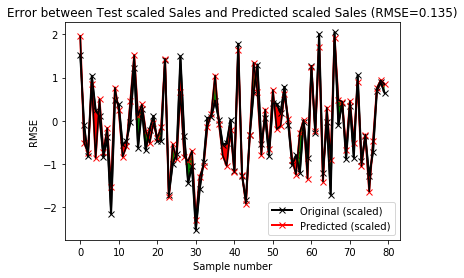

In [52]:
 plot_predicted(y_test, y_predicted, error=e, labels=['Original (scaled)', 'Predicted (scaled)'])

### Use inverse transformation to calculate real error

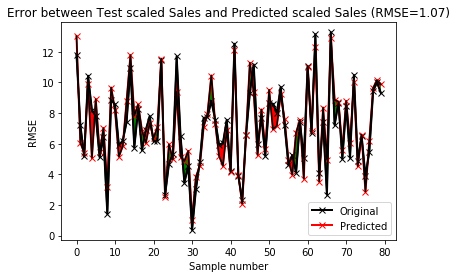

In [53]:
    sales_mean = scaler.mean_[0]
    sales_std = np.sqrt(scaler.var_[0])
    y_predicted_inverse = y_predicted*sales_std + sales_mean
    y_test_inverse = y_test*sales_std + sales_mean
    e = mean_squared_error(y_test_inverse, y_predicted_inverse)
    plt.figure()
    plot_predicted(y_test_inverse, y_predicted_inverse, error=e, labels=['Original', 'Predicted'])